In [1]:
import pandas as pd
import json, requests
import matplotlib.pyplot as plt
import seaborn as snd
%matplotlib inline
import numpy as np
import calendar
import datetime
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from io import StringIO
from sklearn.metrics import mean_squared_error
from pmdarima.arima import ADFTest
from pandas.tseries.offsets import DateOffset
import warnings as warn
warn.filterwarnings("ignore")

C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
dataindia=pd.read_csv(r"C:\Users\User\Desktop\kaggle\time series india\covid_19_india.csv")
dataindia.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


# States Affected

In [3]:
dataindiag=dataindia["State/UnionTerritory"].value_counts()
dataindiag

Kerala                                      186
Delhi                                       154
Rajasthan                                   153
Haryana                                     152
Uttar Pradesh                               152
Ladakh                                      149
Tamil Nadu                                  149
Karnataka                                   147
Punjab                                      147
Maharashtra                                 147
Jammu and Kashmir                           147
Andhra Pradesh                              144
Uttarakhand                                 141
Odisha                                      140
Puducherry                                  138
West Bengal                                 138
Chandigarh                                  137
Chhattisgarh                                137
Gujarat                                     136
Madhya Pradesh                              135
Himachal Pradesh                        

# Total cases in all the States

In [4]:
total_case_india=dataindia[["State/UnionTerritory","Confirmed"]]
total_case_india=total_case_india.groupby(["State/UnionTerritory"]).agg("max").reset_index()

In [5]:
total_case_india=total_case_india.sort_values("Confirmed",ascending=False)

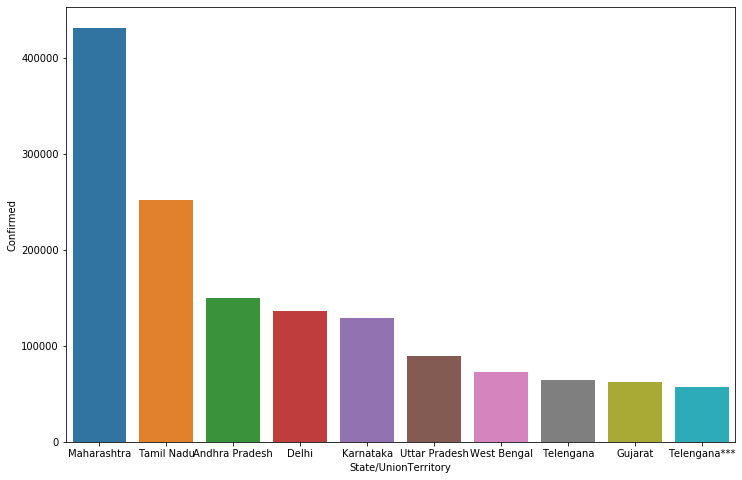

In [6]:
plt.figure(figsize=(12,8))
snd.barplot(x='State/UnionTerritory',y='Confirmed',data=total_case_india[:10])

# Dropping columns that we dont want

In [7]:
dataindia=dataindia.drop(["Time","ConfirmedIndianNational","ConfirmedForeignNational","Sno","Cured","Deaths"],axis=1)

In [8]:
dataindia.head()

,Date,State/UnionTerritory,Confirmed
0,30/01/20,Kerala,1
1,31/01/20,Kerala,1
2,01/02/20,Kerala,2
3,02/02/20,Kerala,3
4,03/02/20,Kerala,3


# We want to do our forecasting for state Maharashtra.. so removing all other states

In [9]:
indexNames = dataindia[ dataindia['State/UnionTerritory'] != "Maharashtra" ].index
datamaha=dataindia.drop(indexNames)

## changing confirmed value in third row 

In [10]:
datamaha.loc[97, "Confirmed"]=8
datamaha.head()

,Date,State/UnionTerritory,Confirmed
76,09/03/20,Maharashtra,2
91,10/03/20,Maharashtra,5
97,11/03/20,Maharashtra,8
120,12/03/20,Maharashtra,11
133,13/03/20,Maharashtra,14


# Parsing dates and extracting Month name

In [11]:
dates=pd.date_range(start="2020-03-09",freq="D",periods=len(datamaha))
datamaha["Month"]=dates.month_name()
datamaha.head()

,Date,State/UnionTerritory,Confirmed,Month
76,09/03/20,Maharashtra,2,March
91,10/03/20,Maharashtra,5,March
97,11/03/20,Maharashtra,8,March
120,12/03/20,Maharashtra,11,March
133,13/03/20,Maharashtra,14,March


# Setting dates as Index to get datetimeindex and Removing Date column


In [12]:
datamaha.set_index(dates,inplace=True)
datamaha=datamaha.drop(["Date"],axis=1)
datamaha.tail()

,State/UnionTerritory,Confirmed,Month
2020-07-29,Maharashtra,391440,July
2020-07-30,Maharashtra,400651,July
2020-07-31,Maharashtra,411798,July
2020-08-01,Maharashtra,422118,August
2020-08-02,Maharashtra,431719,August


# Rise of Confirmed Cases in Every Month

In [13]:
Monthly_data=datamaha[["Month","Confirmed"]]
Monthly_data=Monthly_data.groupby(["Month"]).agg("max").reset_index()
Monthly_data=Monthly_data.sort_values("Confirmed",ascending=True)

In [14]:
Monthly_data

,Month,Confirmed
4,March,216
0,April,9915
5,May,65168
3,June,169883
2,July,411798
1,August,431719


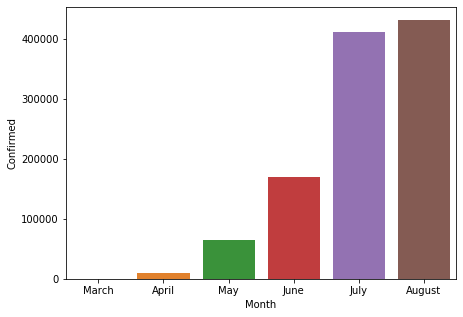

In [15]:
plt.figure(figsize=(7,5))
snd.barplot(x="Month", y="Confirmed",data=Monthly_data)

# Creating a new column with 1 shift so that we can subtract the confirmed cases with the earlier date to get the new cases every day

In [16]:
datamaha["Confirmed1"]=datamaha[["Confirmed"]]
datamaha["Confirmed1"]=datamaha["Confirmed1"].shift(1)
datamaha["Newcases"]=datamaha["Confirmed"] - datamaha["Confirmed1"] 
datamaha.head()

,State/UnionTerritory,Confirmed,Month,Confirmed1,Newcases
2020-03-09,Maharashtra,2,March,NaN,NaN
2020-03-10,Maharashtra,5,March,2.0,3.0
2020-03-11,Maharashtra,8,March,5.0,3.0
2020-03-12,Maharashtra,11,March,8.0,3.0
2020-03-13,Maharashtra,14,March,11.0,3.0


# as we will work on Newcases ,we can remove the other unwanted columns

In [17]:
datamaha=datamaha.drop(["Confirmed","Confirmed1"],axis=1)
datamaha.head()

,State/UnionTerritory,Month,Newcases
2020-03-09,Maharashtra,March,NaN
2020-03-10,Maharashtra,March,3.0
2020-03-11,Maharashtra,March,3.0
2020-03-12,Maharashtra,March,3.0
2020-03-13,Maharashtra,March,3.0


## Replace NAN value with 2 as cases on first day were 2 and replacing negative values with 1

In [18]:
datamaha=datamaha.fillna(2)
datamaha["Newcases"][datamaha["Newcases"] < 0 ]= 1
datamaha.head(3)

,State/UnionTerritory,Month,Newcases
2020-03-09,Maharashtra,March,2.0
2020-03-10,Maharashtra,March,3.0
2020-03-11,Maharashtra,March,3.0


## plotting the rise in covid cases in Maharastra

Text(0, 0.5, 'Newcases')

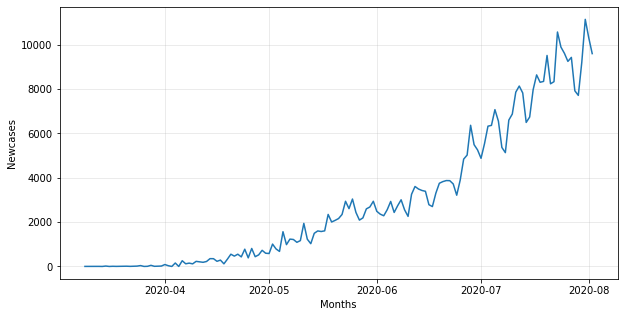

In [19]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(10,5))
plt.grid(axis='both', alpha=.3)
#datamaha["Newcases"].plot()
plt.plot(datamaha["Newcases"])
plt.xlabel("Months")
plt.ylabel("Newcases")

## calculating rolling mean and rolling standard deviation

In [20]:
rolmean=datamaha["Newcases"].rolling(window=12).mean()
rolstd=datamaha["Newcases"].rolling(window=12).std()

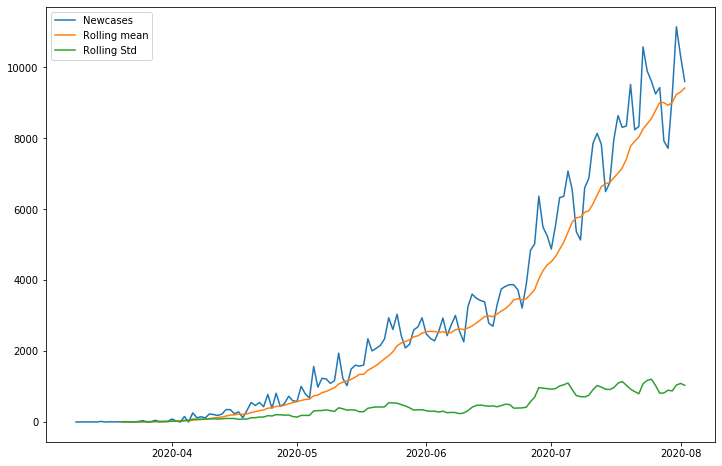

In [21]:
plt.figure(figsize=(12,8))
plt.plot(datamaha["Newcases"],label='Newcases')
plt.plot(rolmean,label="Rolling mean")
plt.plot(rolstd,label="Rolling Std")
plt.legend(loc="best")
plt.show(block=False)

# Decompostion of timeseries

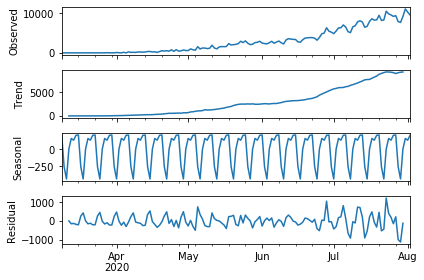

In [22]:
decompostion=sm.tsa.seasonal_decompose(datamaha["Newcases"])
fig=decompostion.plot()

# Lets check whether our time series is stationary or not with Dicky fuller Test

In [23]:
from statsmodels.tsa.stattools import adfuller 

# adfuller gives us below values 
1.ADF test stat

2.p-value

3.Lags used

4.Number of obs


In [24]:
stationary_result=adfuller(datamaha["Newcases"])
#print(stationary_result)

### Lets create a function 

In [25]:
def stationfnct(stationary_result): 
    labels=["ADF test stat","p-value","Lags used","no of obs"]
    for value,label in zip(stationary_result,labels):
            print(label+" : "+str(value)) 
            
stationfnct(stationary_result)            

ADF test stat : 2.729029928228282
p-value : 0.9990879983291504
Lags used : 10
no of obs : 136


# Checking stationarity with Auto.Arima

In [26]:
#adf_test=ADFTest(alpha=0.05)
#adf_test.should_diff(datamaha["Newcases"])


# Converting non stationary series to stationary through differencing.

In [27]:
datamaha["Differencing"]=datamaha["Newcases"]-datamaha["Newcases"].shift(2)
datamaha=datamaha.dropna()
datamaha.head()

,State/UnionTerritory,Month,Newcases,Differencing
2020-03-11,Maharashtra,March,3.0,1.0
2020-03-12,Maharashtra,March,3.0,0.0
2020-03-13,Maharashtra,March,3.0,0.0
2020-03-14,Maharashtra,March,0.0,-3.0
2020-03-15,Maharashtra,March,18.0,15.0


## Again testing for stationarity with the above created function

In [28]:
stationfnct(adfuller(datamaha["Differencing"].dropna()))
stationary_result=adfuller(datamaha["Differencing"].dropna())
print(stationary_result)

ADF test stat : -1.7507003364906264
p-value : 0.40519742113561197
Lags used : 14
no of obs : 130
(-1.7507003364906264, 0.40519742113561197, 14, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 1957.8773755255222)


In [29]:
rolmean=datamaha["Differencing"].rolling(window=12).mean()
rolstd=datamaha["Differencing"].rolling(window=12).std()


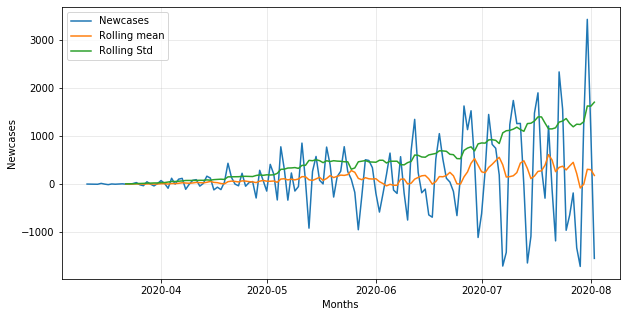

In [30]:
plt.figure(figsize=(10,5))
plt.grid(axis='both', alpha=.3)
plt.plot(datamaha["Differencing"],label="Newcases")
plt.plot(rolmean,label="Rolling mean")
plt.plot(rolstd,label="Rolling Std")
plt.xlabel("Months")
plt.ylabel("Newcases")
plt.legend(loc="best")
plt.show(block=False)

# Now we have a stationary time series

# Auto correlation and Partial auto correlation

In [31]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# To obtain AR(p) , MA(q) values, we perform acf and pcf

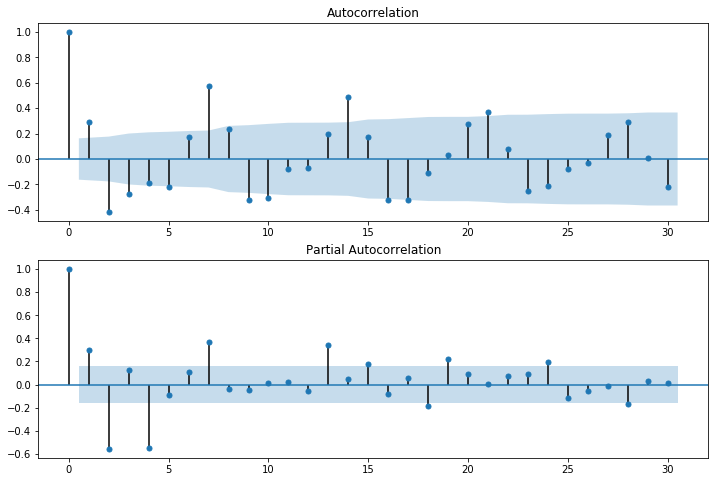

In [32]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(datamaha["Differencing"].dropna(),lags=30,ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(datamaha["Differencing"].dropna(),lags=30,ax=ax2)

#p=2 or 3

#q=1 or 2

#d=2 (how many times we shifted)

In [33]:
#from pmdarima.arima import auto_arima

#model = auto_arima(datamaha_train["Newcases"], trace=True, error_action='ignore', suppress_warnings=True)
#model.fit(datamaha_train["Newcases"])

#forecast = model.predict(n_periods=len(datamaha_test["log"]))
#forecast = pd.DataFrame(forecast,index = datamaha_test["log"].index,columns=['Prediction'])

#plot the predictions for validation set
#plt.plot(datamaha_train["log"], label='Train')
#plt.plot(datamaha_test["log"], label='Valid')
#plt.plot(forecast, label='Prediction')
#plt.show()

# Fitting the model with seasonal ARIMAX

In [34]:
model=sm.tsa.statespace.SARIMAX(datamaha["Newcases"],order=(3,2,2),seasonal_order=(3,2,2,2))
resultss=model.fit()

# Actual vs Predicted Graph

Text(0, 0.5, 'Newcases')

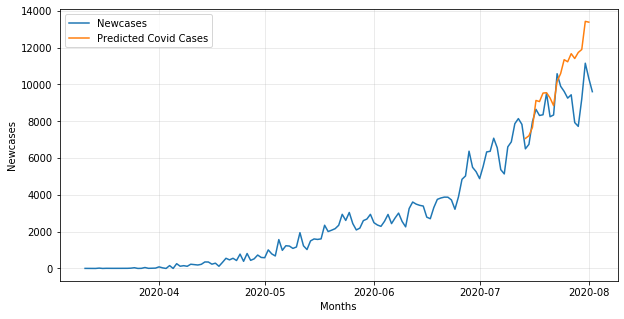

In [35]:
datamaha["Expected_NewCases"]=resultss.predict(start=125,end=143,dynamic=True)
#datamaha[["Expected_Cases","Newcases"]].plot(figsize=(12,8))
plt.figure(figsize=(10,5))
plt.grid(axis='both', alpha=.3)
#plt.plot(datamaha[["Expected_Cases","Newcases"]])
plt.plot(datamaha["Newcases"],label="Newcases")
plt.plot(datamaha["Expected_NewCases"],label="Predicted Covid Cases")
plt.legend(loc="best")
plt.xlabel("Months")
plt.ylabel("Newcases")

# Importing 60 Future days and concatenating our main data set with it

In [36]:
future_dates=[datamaha.index[-1] + DateOffset(days=x) for x in range(0,60)]
future_dateset=pd.DataFrame(index=(future_dates[1:]),columns=datamaha.columns)

In [37]:
datamaha.shape

(145, 5)

In [38]:
futureisreal=pd.concat([datamaha,future_dateset])

# Expected Covid Cases for Next 2 Months

Text(0, 0.5, 'Newcases')

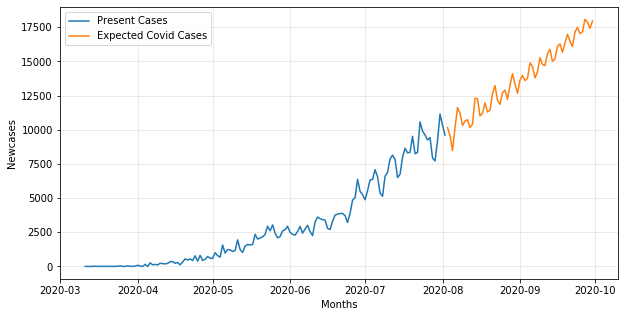

In [39]:
plt.figure(figsize=(10,5))
plt.grid(axis='both', alpha=.3)
#datamaha["Newcases"].plot()
#plt.plot(datamaha["Newcases"])
futureisreal["Expected_NewCases"]=resultss.forecast(steps=62)
plt.plot(futureisreal["Newcases"],label="Present Cases")
plt.plot(futureisreal["Expected_NewCases"],label="Expected Covid Cases")
plt.legend(loc="best")
#plt.plot(futureisreal[["Expected_Cases","Present"]])
plt.xlabel("Months")
plt.ylabel("Newcases")

In [40]:
futureisreal=futureisreal.drop(["Differencing","Newcases"],axis=1)

In [41]:
futureisreal=futureisreal["2020-08-03":]

In [42]:
datess=pd.date_range(start="2020-08-03",freq="D",periods=len(futureisreal))

In [43]:
futureisreal["State/UnionTerritory"]="Maharashtra"
futureisreal["Month"]=datess.month_name()
futureisreal.head()

,State/UnionTerritory,Month,Expected_NewCases
2020-08-03,Maharashtra,August,10155.483358
2020-08-04,Maharashtra,August,9571.667766
2020-08-05,Maharashtra,August,8474.030109
2020-08-06,Maharashtra,August,10154.782033
2020-08-07,Maharashtra,August,11623.248460


In [45]:
Monthly_future_data=futureisreal[["Month","Expected_NewCases"]]
Monthly_future_data=Monthly_future_data.groupby(["Month"]).agg(sum).reset_index()
#Monthly_data=Monthly_data.sort_values("Confirmed",ascending=True)

In [46]:
Monthly_future_data.head()

,Month,Expected_NewCases
0,August,335875.398658
1,September,472754.166342


# Total Number of Newases In the Month of August and September

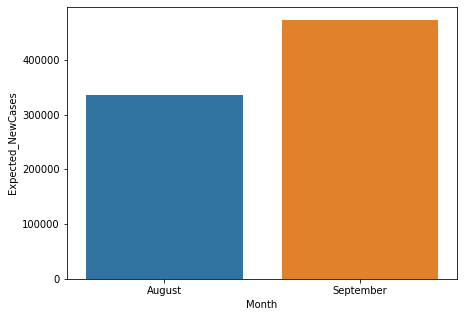

In [48]:
plt.figure(figsize=(7,5))
snd.barplot(x="Month", y="Expected_NewCases",data=Monthly_future_data)